# Co-Simulation

In this example, we simulate a basic energy system of a small datacenter equipped with on-site solar power and a simple battery.

In [1]:
from vessim.actor import ComputingSystem, Generator
from vessim.controller import Monitor
from vessim.cosim import Environment
from vessim.power_meter import MockPowerMeter
from vessim.signal import HistoricalSignal
from vessim.storage import SimpleBattery

# Hotfix to execute asyncio in Jupyter
import nest_asyncio
nest_asyncio.apply()

We define an `Environment` with a single `Microgird` that comprises

- A simulated `ComputingSystem` with two servers that consistently draw 200W and 250W, respectively. The datacenter has a [power usage effectiveness](https://en.wikipedia.org/wiki/Power_usage_effectiveness) of 1.6, resulting in a total power demand of 1.6 * (200 W + 250 W) = 720 W.
- A `Generator` which represents a solar panel in Berlin, modeled according to the dataset `solcast2022_global` that comes with Vessim (see "Signal" example).
- A `SimpleBattery` with a usable capacity of 100 Wh which is charged with 1Wh.
- A `Monitor` which periodically stores the microgrid state and eventually writes it to a CSV file.

In [2]:
environment = Environment(sim_start="2022-06-09 00:00:00")

monitor = Monitor()  # stores simulation result on each step
environment.add_microgrid(
    actors=[
        ComputingSystem(power_meters=[MockPowerMeter(p=200), MockPowerMeter(p=250)], pue=1.6),
        Generator(
            signal=HistoricalSignal.from_dataset("solcast2022_global", params={"scale": 5000}),
            column="Berlin",
        ),
    ],
    controllers=[monitor],
    storage=SimpleBattery(capacity=100 *10000, charge_level=100 *10000),
    step_size=60,  # global step size (can be overridden by actors or controllers)
)

environment.run(until=24 * 3600)  # 24h
monitor.to_csv("result.csv")

2024-04-04 13:31:51.450 | INFO     | mosaik.scenario:start:280 - Starting "Actor" as "Actor-0" ...
2024-04-04 13:31:51.451 | INFO     | mosaik.scenario:start:280 - Starting "Actor" as "Actor-1" ...
2024-04-04 13:31:51.452 | INFO     | mosaik.scenario:start:280 - Starting "Grid" as "Grid-0" ...
2024-04-04 13:31:51.452 | INFO     | mosaik.scenario:start:280 - Starting "Controller" as "Controller-0" ...
2024-04-04 13:31:51.454 | INFO     | mosaik.scenario:run:598 - Starting simulation.
100%|██████████| 86400/86400 [00:00<00:00, 161076.02steps/s]
2024-04-04 13:31:51.993 | INFO     | mosaik.scenario:run:646 - Simulation finished successfully.


For example, we can observe that at 10pm, the battery is fully drained and there is also no solar power production at night.
The resulting $p_{delta}$ of -720 
W has to be drawn from the public grid.

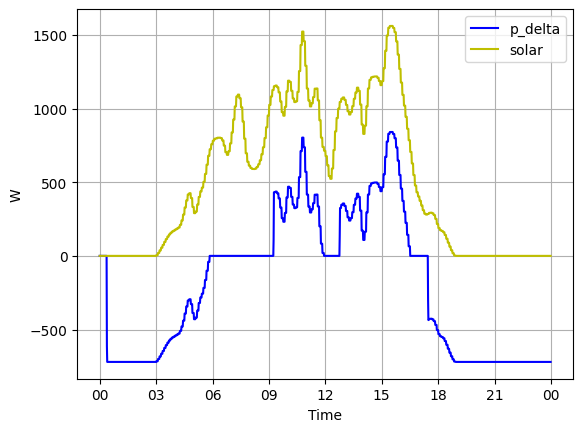

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = pd.read_csv("result.csv", parse_dates=[0], index_col=0)

fig, ax1 = plt.subplots()

ax1.plot(df.index, df["p_delta"], color="b", label="p_delta")
ax1.legend()
ax1.plot(df.index, df["actor_infos.Generator-0.p"], color="y", label="solar")
ax1.legend()
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
ax1.grid()
ax1.set_xlabel("Time")
ax1.set_ylabel("W")

plt.show()